# Naive Bayes Implementation

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

from helpingFunctions import CustomNaiveBayes

### Data Loading and Cleaning

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 
           'marital.status', 'occupation', 'relationship', 'race', 'sex', 
           'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

df = pd.read_csv("adult.csv")

categorical_cols = ['workclass', 'education', 'marital.status', 'occupation', 
                    'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 
                    'hours.per.week', 'native.country']
target_col = 'income'

df = df[categorical_cols + [target_col]]
df = df.fillna('Missing')
df = df.replace('?', 'Missing')
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

print(f"Dataset Shape: {df.shape}")

Dataset Shape: (32561, 12)


### Encoding and Splitting

In [3]:
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df[categorical_cols].values
y = df[target_col].values

print(df)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# print(f"Train size: {X_train.shape}")
# print(f"Val size:   {X_val.shape}")
# print(f"Test size:  {X_test.shape}")

       workclass  education  marital.status  occupation  relationship  race  \
0              2         11               6           7             1     4   
1              4         11               6           3             1     4   
2              2         15               6           7             4     2   
3              4          5               0           6             4     4   
4              4         15               5          10             3     4   
...          ...        ...             ...         ...           ...   ...   
32556          4         15               4          11             1     4   
32557          4          7               2          13             5     4   
32558          4         11               2           6             0     4   
32559          4         11               6           0             4     4   
32560          4         11               4           0             3     4   

       sex  capital.gain  capital.loss  hours.per.w

### Smoothing Parameter Tuning (Alpha)

Alpha : 0.1 , Accuracy : 0.82125307
Alpha : 0.5 , Accuracy : 0.81900082
Alpha : 1.0 , Accuracy : 0.81490581
Alpha : 2.0 , Accuracy : 0.82186732
Alpha : 5.0 , Accuracy : 0.82022932
Best Alpha: 2.0


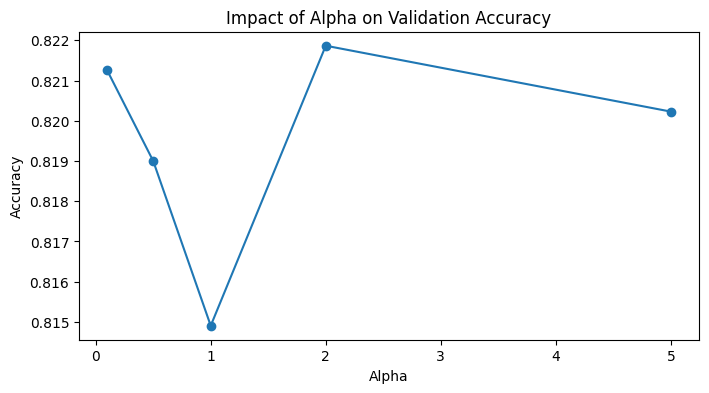

In [5]:
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
val_accuracies = []

best_alpha = 0
best_acc = 0
best_model = None

for a in alphas:
    nb = CustomNaiveBayes(alpha=a)
    nb.fit(X_train, y_train)
    
    preds = nb.predict(X_val)	# predict using validation set
    
    acc = accuracy_score(y_val, preds)	# calculate the accuracy score
    val_accuracies.append(acc)
    
    print(f"Alpha : {a} , Accuracy : {acc:.8f}")
    
    if acc > best_acc:	# for getting the best alpha with the best accuracy
        best_acc = acc
        best_alpha = a
        best_model = nb

print(f"Best Alpha: {best_alpha}")

plt.figure(figsize=(8, 4))
plt.plot(alphas, val_accuracies, marker='o')
plt.title("Impact of Alpha on Validation Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

### Performance

In [6]:
test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
print(f"Test Accuracy (Alpha={best_alpha}): {test_acc:.4f}")
print("-" * 40)
print("\nClassification Report:\n")
print(classification_report(y_test, test_preds))

Test Accuracy (Alpha=2.0): 0.8280
----------------------------------------

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      3709
           1       0.62      0.76      0.68      1176

    accuracy                           0.83      4885
   macro avg       0.77      0.80      0.78      4885
weighted avg       0.84      0.83      0.83      4885



### Feature Selection

In [8]:
for i, col in enumerate(categorical_cols):
    X_train_sub = np.delete(X_train, i, axis=1)
    X_val_sub = np.delete(X_val, i, axis=1)
    
    nb_sub = CustomNaiveBayes(alpha=best_alpha)
    nb_sub.fit(X_train_sub, y_train)
    acc = accuracy_score(y_val, nb_sub.predict(X_val_sub))
    print(f"\n Dropped Feature: {col} , Accuracy : {acc:.4f}")


 Dropped Feature: workclass , Accuracy : 0.8137

 Dropped Feature: education , Accuracy : 0.7926

 Dropped Feature: marital.status , Accuracy : 0.8442

 Dropped Feature: occupation , Accuracy : 0.7971

 Dropped Feature: relationship , Accuracy : 0.8466

 Dropped Feature: race , Accuracy : 0.8237

 Dropped Feature: sex , Accuracy : 0.8329

 Dropped Feature: capital.gain , Accuracy : 0.7914

 Dropped Feature: capital.loss , Accuracy : 0.8098

 Dropped Feature: hours.per.week , Accuracy : 0.8096

 Dropped Feature: native.country , Accuracy : 0.8229


### Probability Analysis

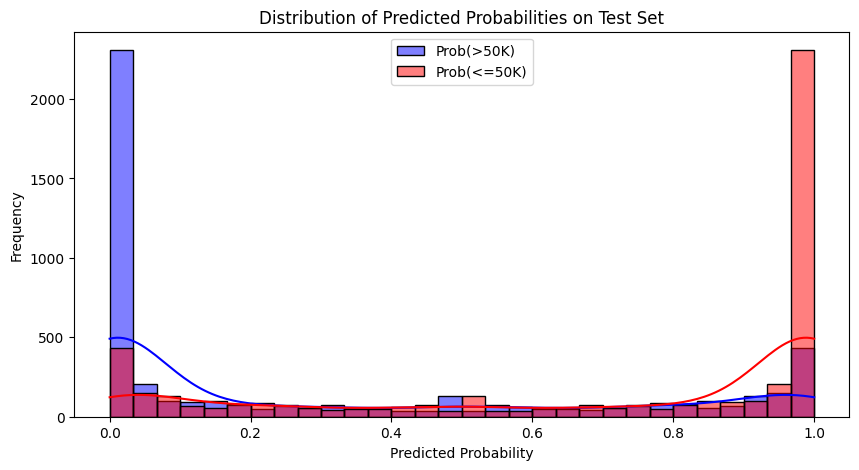

In [9]:
test_probas = best_model.calculate_class_probabilities(X_test)

plt.figure(figsize=(10, 5))
sns.histplot(test_probas[:, 1], bins=30, kde=True, color='blue', label='Prob(>50K)')
sns.histplot(test_probas[:, 0], bins=30, kde=True, color='red', label='Prob(<=50K)')
plt.title("Distribution of Predicted Probabilities on Test Set")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Violation and their Impact

For the "adult" dataset used in this notebook, the model assumes that features like `education`, `occupation`, `marital.status`, and `relationship` are all independent of each other when predicting the `income` class.

#### Violations in the "adult" Dataset :
Some clear examples of correlated features in this dataset are:

- `education` and `occupation`: A person's level of education is often a strong predictor of their occupation.
- `marital.status` and `relationship`: These two features are highly dependent. A marital.status of 'Married-civ-spouse' almost perfectly corresponds to a relationship of 'Husband' or 'Wife'.
- `occupation` and `hours.per.week`: Certain occupations typically demand more (or fewer) hours of work per week.

#### Impact of Violations :
When the independence assumption is violated, the model's posterior probability estimates can become inaccurate. The classifier might "double-count" the evidence from correlated features.

For example, if a high education level and a high-paying occupation both point towards a >50K income, the model might become overly confident in its prediction because it treats these two correlated features as independent pieces of evidence.

### Comparison with Sklearn

Custom Implementation Accuracy: 0.8280
Sklearn Implementation Accuracy: 0.7840


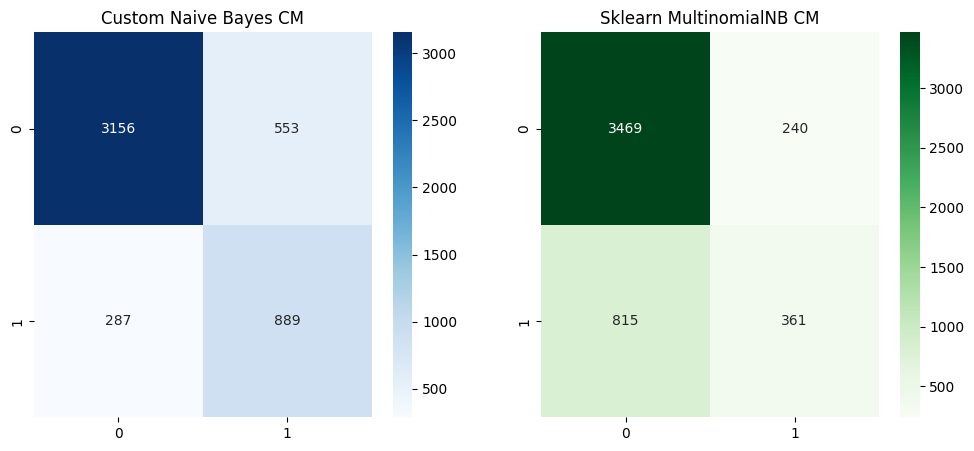

In [10]:
sk_nb = MultinomialNB(alpha=best_alpha)
sk_nb.fit(X_train, y_train)
sk_preds = sk_nb.predict(X_test)
sk_acc = accuracy_score(y_test, sk_preds)

print(f"Custom Implementation Accuracy: {test_acc:.4f}")
print(f"Sklearn Implementation Accuracy: {sk_acc:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Custom Naive Bayes CM")
sns.heatmap(confusion_matrix(y_test, sk_preds), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("Sklearn MultinomialNB CM")
plt.show()